In [6]:
# imported dependencies
import pennylane as qml
from itertools import product
import numpy as np
import random
from helper_functions import generate_density_matrix, create_generators

In [7]:
# Set up Unitary matricies U
U1 = qml.PauliZ(0) @ qml.Identity(1) @ qml.Identity(2)
U1 = U1.matrix()
U2 = qml.Identity(0) @ qml.PauliZ(1) @ qml.Identity(2)
U2 = U2.matrix()
U3 = qml.Identity(0) @ qml.Identity(1) @ qml.PauliZ(2)
U3 = U3.matrix()
U_list = [U1, U2, U3]

# Set up generators and stabilizer list 
G1, G2 = create_generators()
I = (qml.Identity(0) @ qml.Identity(1) @ qml.Identity(2)).matrix()
S = [G1, G2, G1 @ G2, I]
O = (qml.Hadamard(0) @ qml.PauliX([1]) @ qml.Hadamard([2])).matrix()

<br>

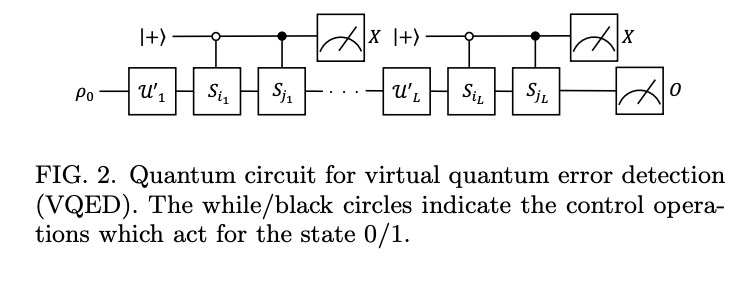

In [8]:
L = len(U_list)
rho_naught = generate_density_matrix()
estimation_wires = list(range(0, L))
target_wires = list(range(L, L+3))

dev = qml.device("default.mixed", wires=(len(estimation_wires+target_wires)))

@qml.qnode(dev)
def VQED(stabilizer_list, unitary_list):
    # stabilizer list is same len as estimation wires

    # initialize target and estimation wires
    qml.QubitDensityMatrix(rho_naught, wires=target_wires)   
    for wire in estimation_wires:
        qml.Hadamard(wires=wire)

    for l in estimation_wires:
        # get the 3 unitary matries 
        s_i = stabilizer_list[l][0]
        s_j = stabilizer_list[l][1]
        U = unitary_list[l]
    
        # apply the gates 
        qml.QubitUnitary(U, wires=target_wires) # Apply U,
        qml.BitFlip(0.5, wires=target_wires[0]) # add some noise (U')
        qml.ControlledQubitUnitary(s_i, control_wires=estimation_wires[l], wires=target_wires, control_values="0")
        qml.ControlledQubitUnitary(s_j, control_wires=estimation_wires[l], wires=target_wires, control_values="1")
    prod = qml.PauliX(estimation_wires[0])
    for wire in range(1,len(estimation_wires)):
        prod = prod @ qml.PauliX(estimation_wires[wire])
    return (qml.expval(prod), 
            qml.expval(qml.Hermitian(O, target_wires)))


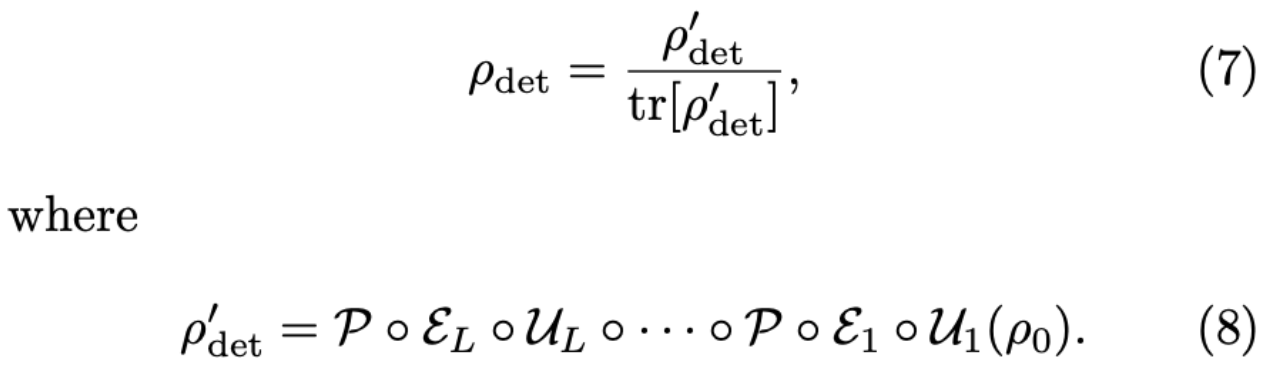

In [9]:
id_target_wires = [0,1,2]
id_dev = qml.device("default.mixed", wires=len(id_target_wires))
@qml.qnode(id_dev)
def get_rho_id(U_list):
  p1 = 0.5 * (I + G1)
  p2 = 0.5 * (I + G2)
  P = p1 @ p2
  rho_naught = generate_density_matrix()
  qml.QubitDensityMatrix(rho_naught, wires=id_target_wires)
  for U in U_list:
    qml.QubitUnitary(U, id_target_wires)
    qml.QubitUnitary(P, id_target_wires)
  return qml.density_matrix(id_target_wires)


def get_real_expval():
  rho_id = get_rho_id(U_list)
  rho_det = rho_id/np.trace(rho_id)
  return np.trace(rho_det @ O)



<br>

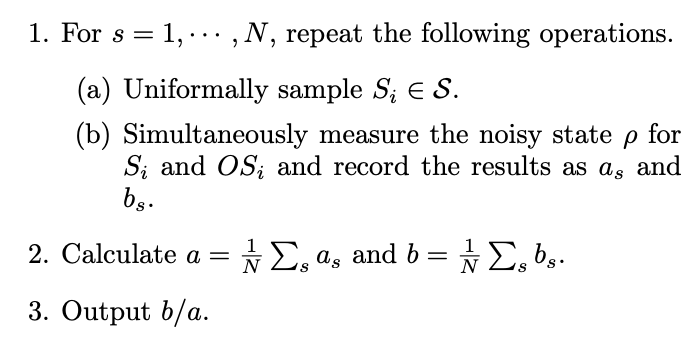


In [10]:
a = 0
b = 0
N = 100
for s in range(N):
    s_sample = [random.sample(S,2) for i in range(L)]
    a_s, O_measurement = VQED(s_sample, U_list)
    b_s = a_s * O_measurement
    a += a_s
    b += b_s

a = a/N
b = b/N

print("Actual Expval:")
actual_expval = b / a
print(actual_expval)

expected_expval = get_real_expval()
print("Expected Expval:")
print(expected_expval)
percent_error = abs((actual_expval - expected_expval) / expected_expval) * 100
percent_error = percent_error.real
print(f"% error: {percent_error}%")

/Users/trevorflanigan/Desktop/VQED/.venv/lib/python3.9/site-packages/pennylane/ops/op_math/controlled.py:254: UserWarning: Specifying control values as a string is deprecated. Please use Sequence[Bool]
  warnings.warn(


Actual Expval:
-0.500000000000029
Expected Expval:
(-0.4999999999999999+0j)
% error: 5.817568649035822e-12%
